In [1]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import torch
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
from PIL import Image
from IPython.display import Image as Img, display
from glob import glob
import cv2
import numpy as np
import random
import time, datetime
from model import *

In [2]:
cfg='darknet/cfg/yolov3.cfg'
wts='darknet/cfg/yolov3.weights'
labels='darknet/cfg/coco.names'
img_size=416
confidence=0.8
nms=0.4

In [3]:
net = Darknet(cfg, img_size=img_size)
net.load_weights(wts)
net.cuda()
net.eval()
classes = open(labels).read().strip().split("\n")
Tensor = torch.cuda.FloatTensor
# net
print(classes)


C:\Users\Admin\Anaconda3\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [4]:
def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
#     print(imw)
#     print(imh)
#     print("Transform")
#     print(max(int((imh-imw)/2),0))
#     print(max(int((imw-imh)/2),0))
    img_transforms=transforms.Compose([transforms.Resize((imh,imw)),
                                     transforms.Pad(
                                         (max(int((imh-imw)/2),0),
                                         max(int((imw-imh)/2),0)),
                                         (128,128,128)),
                                     transforms.ToTensor(),
                                     ])
    image_tensor = img_transforms(img).float().unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    with torch.no_grad():
        detections = net(input_img)
        detections = non_max_suppression(detections, 80, 
                        confidence, nms)
    
    return detections[0]

Inference Time: 0:00:00.364094


<Figure size 432x288 with 0 Axes>

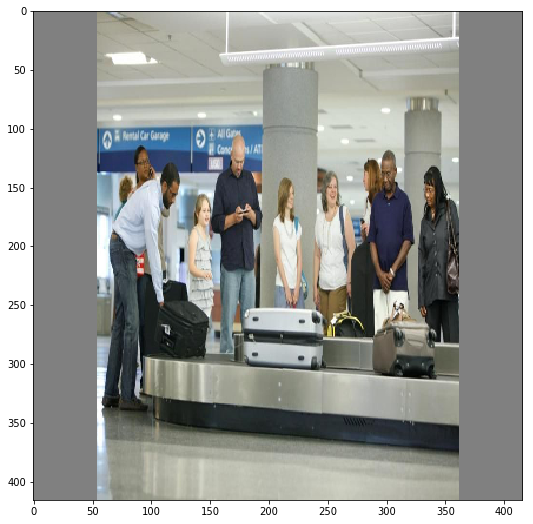

Inference Time: 0:00:00.699212


<Figure size 432x288 with 0 Axes>

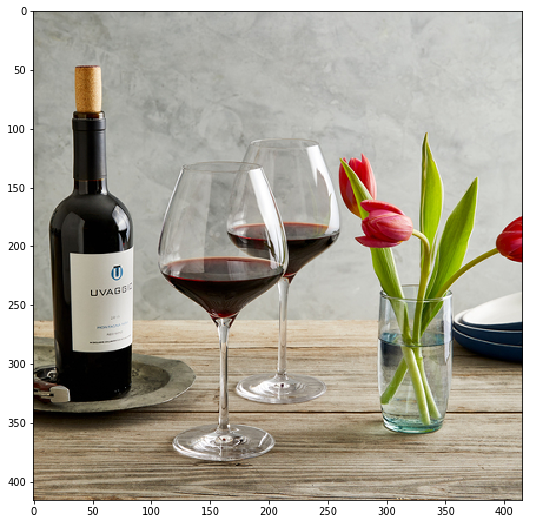

Inference Time: 0:00:01.164799


<Figure size 432x288 with 0 Axes>

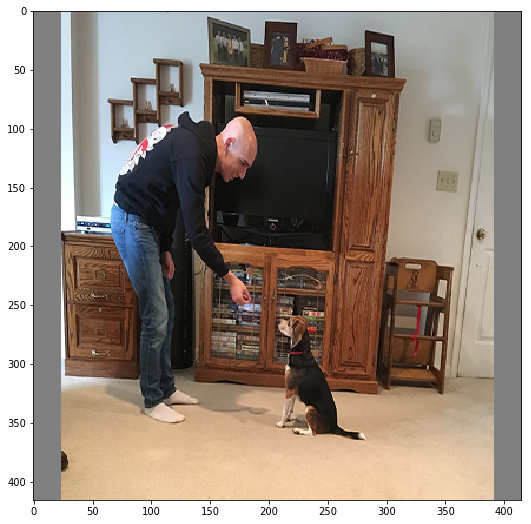

Inference Time: 0:00:01.606637


<Figure size 432x288 with 0 Axes>

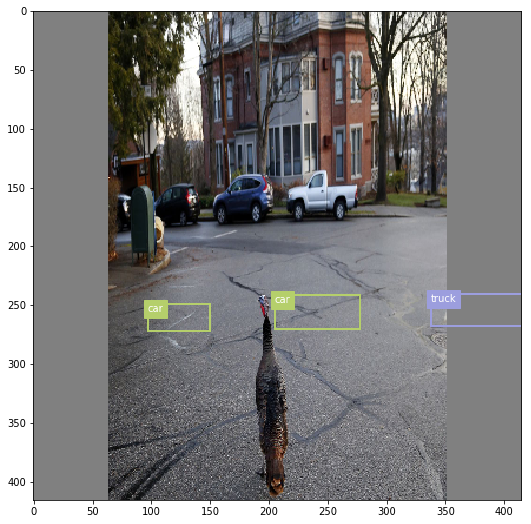

Inference Time: 0:00:02.082374


<Figure size 432x288 with 0 Axes>

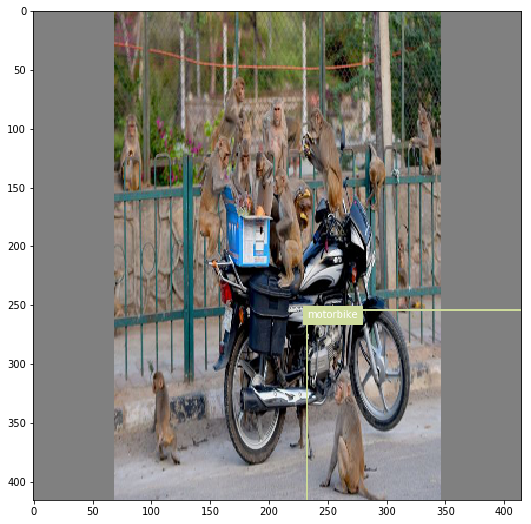

Inference Time: 0:00:02.438930


<Figure size 432x288 with 0 Axes>

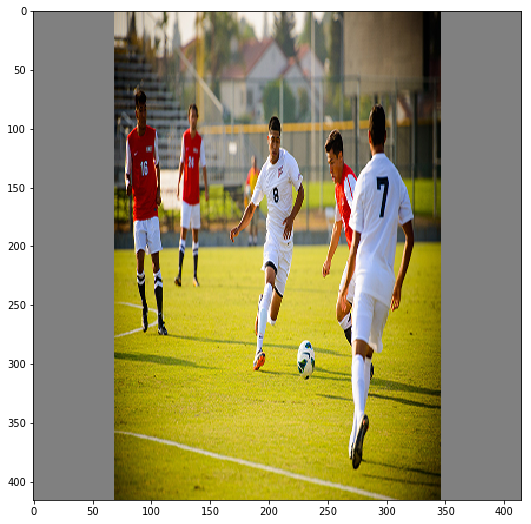

Inference Time: 0:00:03.327938


<Figure size 432x288 with 0 Axes>

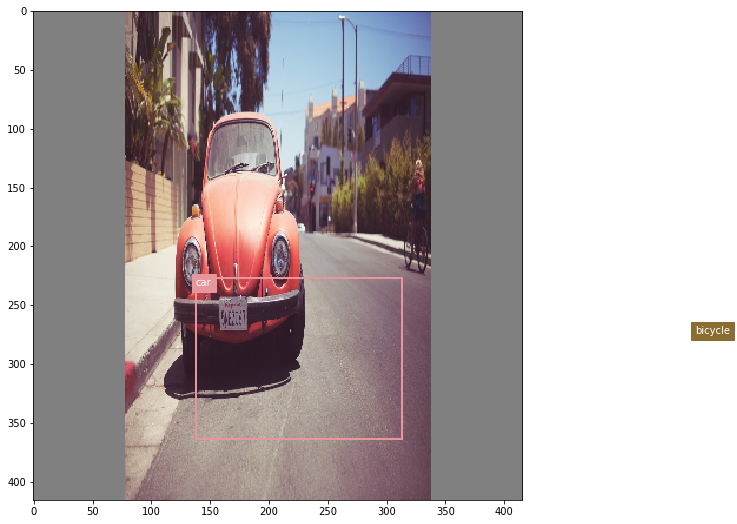

Inference Time: 0:00:03.838491


<Figure size 432x288 with 0 Axes>

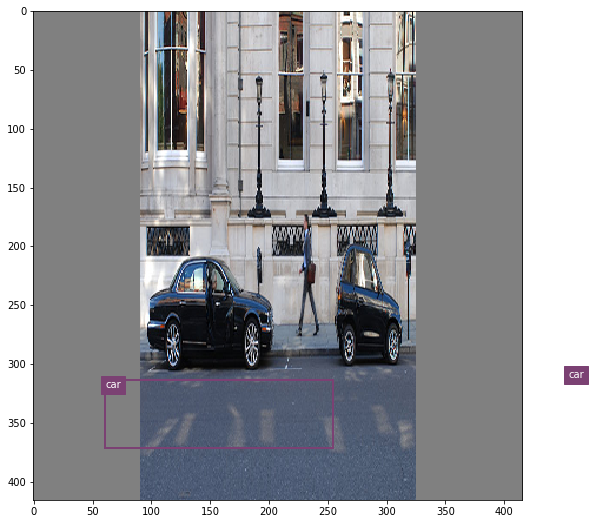

Inference Time: 0:00:04.401078


<Figure size 432x288 with 0 Axes>

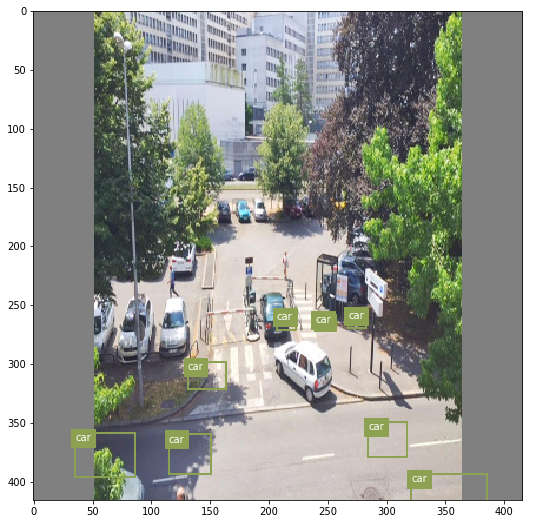

Inference Time: 0:00:04.981376


<Figure size 432x288 with 0 Axes>

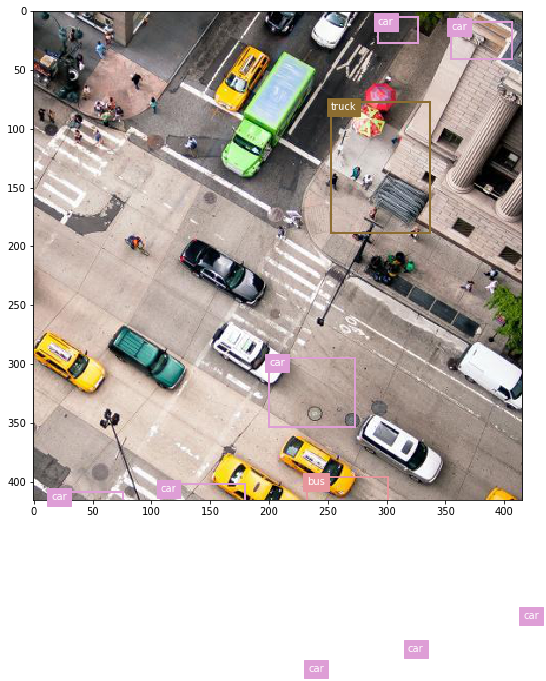

Inference Time: 0:00:05.528902


<Figure size 432x288 with 0 Axes>

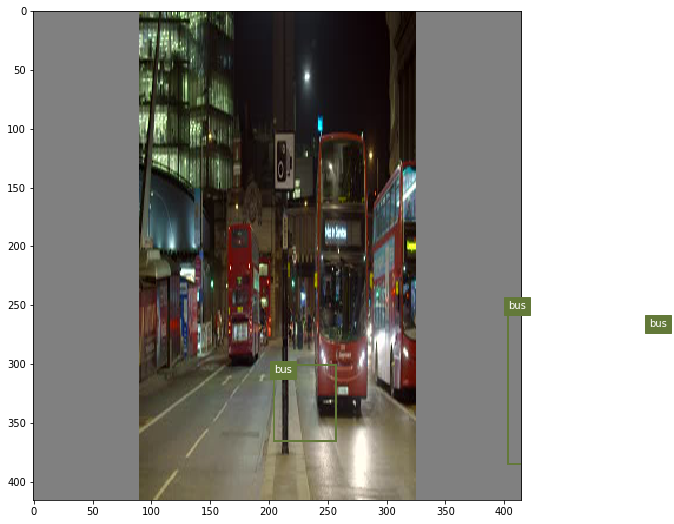

Inference Time: 0:00:07.105905


<Figure size 432x288 with 0 Axes>

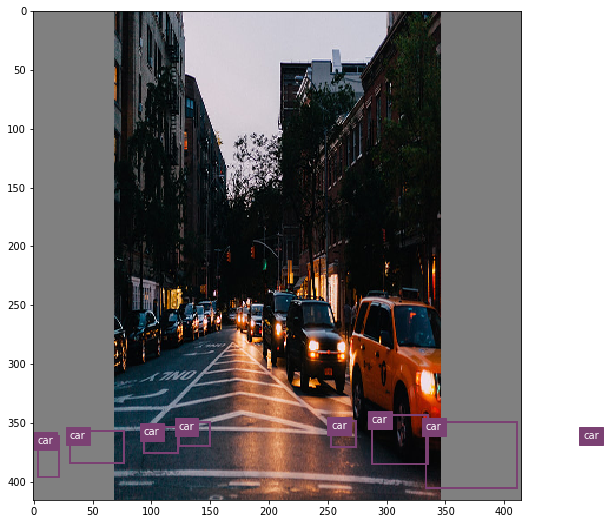

Inference Time: 0:00:07.566469


<Figure size 432x288 with 0 Axes>

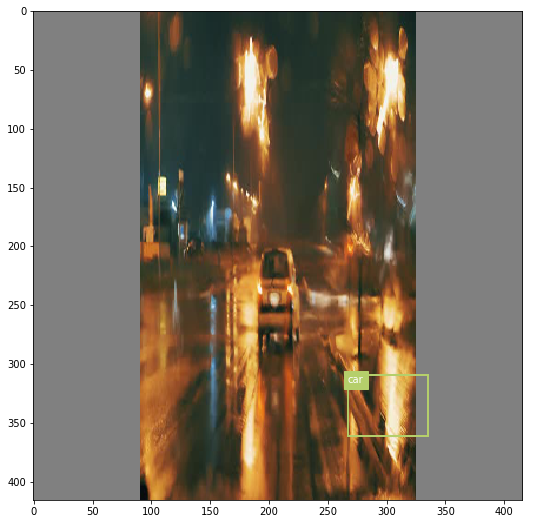

In [6]:
# img_name = "TestImg1.jpg"
# for imageName in glob('imgs/*.JPG'):
#     display(Img(filename=imageName))
start = time.time()
for img_name in glob('images/*.JPG'):
    img = Image.open(img_name)
    detections = detect_image(img)
    inference_time = datetime.timedelta(seconds=time.time() - start)
    print ('Inference Time: %s' % (inference_time))
    cmap = plt.get_cmap('tab20b')
    colors = [cmap(i) for i in np.linspace(0, 1, 20)]
    img = np.array(img)
    plt.figure()
    fig, ax = plt.subplots(1, figsize=(12,9))
    
#     print("shape")
#     print(img.shape)
    
    ratio = min(img_size/img.shape[0], img_size/img.shape[1])
    imw = round(img.shape[0] * ratio)
    imh = round(img.shape[1] * ratio)
#     print("Resize to")
#     print(imw)
#     print(imh)
    img = cv2.resize(img, (imw, imh), interpolation = cv2.INTER_CUBIC)
#     print("shape")
#     print(img.shape)
    
    pad_x = max(int((imh-imw)/2),0)
    pad_y = max(int((imw-imh)/2),0)
    img = cv2.copyMakeBorder( img, pad_y, pad_y, pad_x, pad_x, cv2.BORDER_CONSTANT, value=(128, 128,128))
    ax.imshow(img)
#     print(img.shape)
#     print("pad")
#     print(pad_x)
#     print(pad_y)
#     unpad_h = img_size - pad_y
#     unpad_w = img_size - pad_x
#     print("unpad")
#     print(unpad_w)
#     print(unpad_h)
    if detections is not None:
        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)
        bbox_colors = random.sample(colors, n_cls_preds)
    #     count = 0
        for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
            if int(cls_pred) in range(1, 8):
#                 box_h = y2 - y1
#                 box_w = x2 - x1
#                 y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
#                 x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
    #             count = count + 1
#                 y1 = y1 - pad_y
#                 x1 = x1 - pad_x
#                 y2 = y2 - pad_y
#                 x2 = x2 - pad_x
#                 print(x1)
#                 print(y1)
#                 print(x2)
#                 print(y2)
#                 print(classes[int(cls_pred)])
                box_h = y2 - y1
                box_w = x2 - x1
#                 box_h = ((y2 - y1) / unpad_h) * img.shape[0]
#                 box_w = ((x2 - x1) / unpad_w) * img.shape[1]
#                 y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
#                 x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
                color = bbox_colors[int(np.where(
                     unique_labels == int(cls_pred))[0])]
                bbox = patches.Rectangle((x1, y1), box_w, box_h,
                     linewidth=2, edgecolor=color, facecolor='none')
                ax.add_patch(bbox)
                plt.text(x1, y1, s=classes[int(cls_pred)], 
                        color='white', verticalalignment='top',
                        bbox={'color': color})
    plt.show()